# Quick start - пишем простое решение

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from tqdm.notebook import tqdm

In [2]:
!ls /kaggle/input/competative-data-science-course-by-data-feeling/

ls: cannot access '/kaggle/input/competative-data-science-course-by-data-feeling/': No such file or directory


# Анализируем данные о машинах car_info

(2337, 9)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_2
1574,g-2250790z,Smart Coupe,economy,petrol,4.64,2017,52883,2020,break_bug
361,y-8703326K,Smart ForFour,economy,petrol,4.40,2013,22930,2021,engine_ignition
1932,J-8994437j,Kia Sportage,standart,petrol,5.28,2015,16625,2017,engine_ignition
1041,e-7981708c,VW Polo,economy,petrol,5.68,2015,23226,2016,break_bug
504,O-1538477T,Kia Sportage,standart,petrol,5.66,2011,52943,2021,another_bug


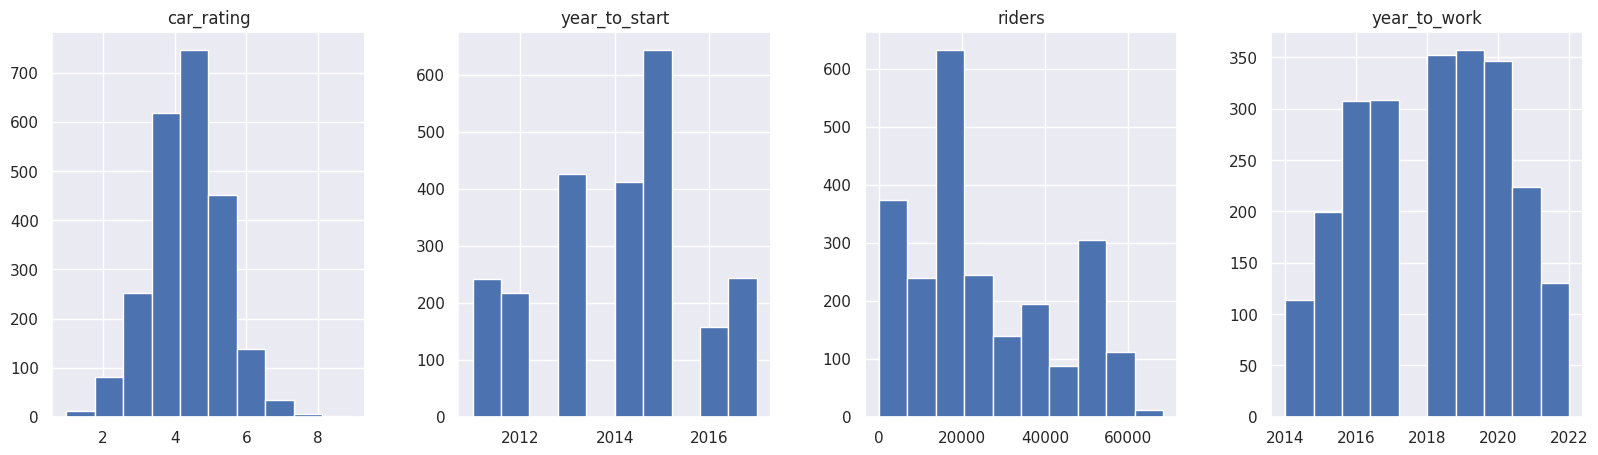

In [3]:
path = '../data/car_train.csv'
train = pd.read_csv(path).drop('target_1', axis=1)
print(train.shape)
train.hist(figsize=(25, 5), layout = (-1, 5))
train.sample(5)

In [4]:
path = '../data/car_test.csv'
test = pd.read_csv(path).drop('target_1', axis=1)
print(test.shape)
test.sample(5)

(1913, 9)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_2
1912,W-2056430t,Smart Coupe,economy,petrol,5.34,2017,57209,2022,gear_stick
326,G17377477X,Skoda Rapid,economy,petrol,4.14,2014,2008,2016,engine_check
346,T-9486823A,VW Polo,economy,petrol,4.46,2014,2658,2016,wheel_shake
836,X-1044519H,Hyundai Solaris,economy,petrol,5.00,2012,33578,2020,gear_stick
1216,m-1537869D,VW Polo VI,economy,petrol,5.44,2015,20867,2020,engine_check


# Классифицируем признаки на типы

In [5]:
features2drop = ['car_id'] 
targets = ['target_2']  
cat_features = ['car_type', 'fuel_type', 'model'] 

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_2']


# Обучаем Catboost и делаем прогноз на тест

In [9]:
!pip install catboost -q
from catboost import Pool, CatBoostClassifier #, CatBoostRegressor 
from sklearn.model_selection import KFold # k-фолдная валидация

In [ ]:

targets = ['target_2']

X = car_train[filtered_features].drop(targets, axis=1, errors='ignore')
y = car_train[targets]

clf = CatBoostClassifier(iterations = 700,
                      loss_function='MultiClass', 
                      random_seed=42,                          
                      colsample_bylevel =  0.098,
                      subsample = 0.95,
                      min_data_in_leaf = 243,
                      cat_features = cat_features,
                      bootstrap_type='Bernoulli')


clf.fit(X = X, y = y, verbose = 250, plot = False)

# инференс модели
y_pred = np.zeros((test.shape[0], 9)) # массив для записи финального результата
y_pred += clf.predict_proba(test[filtered_features])#[:,1]

In [ ]:
car_test['target_2'] = clf.predict(car_test[filtered_features])
car_test[['car_id', 'target_2']].to_csv('simple_baseline_v1.csv', index=False)

# Добавим информацию про поездки из rides

In [ ]:
path = '../data/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

In [ ]:

f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('speed_avg', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

In [ ]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
car_train = add_featues(car_train)
car_test = add_featues(car_test)

In [ ]:
car_train.sample(2)

# Снова обновляем типы фичей

In [ ]:
features2drop = ['car_id'] 
targets = ['target_2']  
cat_features = ['car_type', 'fuel_type', 'model'] 

filtered_features = [i for i in car_train.columns if (i not in targets and i not in features2drop)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

# Обучаем Catboost на новых данных и делаем новый прогноз

In [ ]:
targets = ['target_2']

X = car_train[filtered_features].drop(targets, axis=1, errors='ignore')
y = car_train[targets]

clf = CatBoostClassifier(iterations = 700,
                      loss_function='MultiClass', 
                      random_seed=42,                          
                      colsample_bylevel =  0.098,
                      subsample = 0.95,
                      min_data_in_leaf = 243,
                      cat_features = cat_features,
                      bootstrap_type='Bernoulli')


clf.fit(X=X, y=y, verbose = 250, plot = False)

# инференс модели
y_pred = np.zeros((car_test.shape[0], 9)) # массив для записи финального результата
y_pred += clf.predict_proba(car_test[filtered_features])#[:,1]

In [ ]:
car_test['target_2'] = clf.predict(car_test[filtered_features])
car_test[['car_id', 'target_2']].to_csv('../subs/simple_baseline_v2.csv', index=False)

# Что дальше?

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Типо схрания `Save & Run All (Commit)`
- Жем нижную кнопку `Save`